In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

In [3]:
filename = 'jena_climate_2009_2016.csv'

with open(filename) as f:
    data = f.read()

    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    print(header)
    print(len(lines))

for line in lines[:10]:
    print(line)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.

In [4]:
import numpy as np
n_lines = len(lines)
n_headers = len(header)
temperature = np.zeros((n_lines,))
raw_data = np.zeros((n_lines, n_headers - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # 1: to skip the date time column
    temperature[i] = values[1]
    raw_data[i,] = values

print(temperature[:3])
print(raw_data[:3, :3])

[-8.02 -8.41 -8.51]
[[996.52  -8.02 265.4 ]
 [996.57  -8.41 265.01]
 [996.53  -8.51 264.91]]


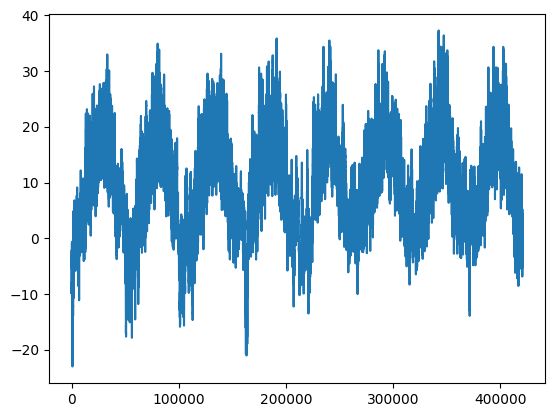

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(n_lines), temperature)

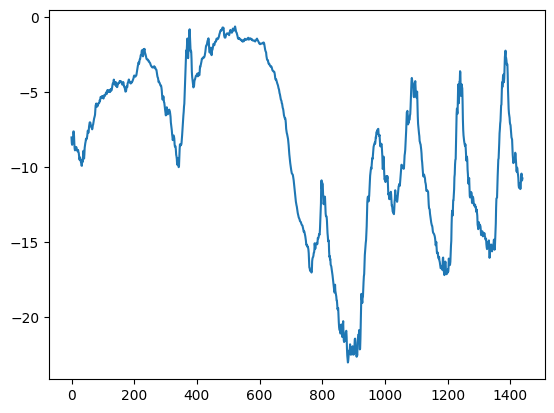

In [6]:
plt.plot(range(1440), temperature[:1440])

In [7]:
n_train = int(0.5 * n_lines)
n_val = int(0.25 * n_lines)
n_test = n_lines - n_train - n_val
print(n_train, n_val, n_test)

210225 105112 105114


In [22]:
print(raw_data[:3,:3])
mean = raw_data[:n_train].mean(axis=0)
std = raw_data[:n_train].std(axis=0)
z = (raw_data - mean) / std
print(z[:n_train].mean(axis=0), z[:n_train].std(axis=0))

[[996.52  -8.02 265.4 ]
 [996.57  -8.41 265.01]
 [996.53  -8.51 264.91]]
[ 2.41448143e-12 -3.04937772e-15  6.68831382e-13 -1.47390162e-14
  3.51971409e-15  5.17726056e-15 -1.97806893e-14 -1.56825520e-14
  3.62590596e-14  3.44193167e-15 -2.11724873e-13  1.60843651e-14
 -5.38064190e-14 -2.19450964e-15] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    z[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    z[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train,
    end_index=n_train + n_val
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    z[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train + n_val
)

In [28]:
for samples, targets in train_dataset:
    print('batch samples shape: ', samples.shape)
    print('batch targets shape: ', targets.shape)
    break

batch samples shape:  (256, 120, 14)
batch targets shape:  (256,)


In [26]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(evaluate_naive_method(train_dataset), evaluate_naive_method(val_dataset), evaluate_naive_method(test_dataset))

2.6916438277703816 2.4417326002413864 2.622035888818064


In [32]:
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, callbacks

inputs = layers.Input(shape=(sequence_length, z.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation=activations.relu)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
callback_list = [
    callbacks.ModelCheckpoint('jena_dense', save_best_only=True)
]
model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callback_list)

model = keras.models.load_model('jena_dense')
print(model.evaluate(test_dataset))


Epoch 1/10
807/819 [============================>.] - ETA: 0s - loss: 13.1448 - mean_absolute_error: 2.8071INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 13s 15ms/step - loss: 13.1108 - mean_absolute_error: 2.8036 - val_loss: 13.3885 - val_mean_absolute_error: 2.9012
Epoch 2/10
809/819 [============================>.] - ETA: 0s - loss: 9.4406 - mean_absolute_error: 2.4182INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 12s 15ms/step - loss: 9.4468 - mean_absolute_error: 2.4191 - val_loss: 11.6426 - val_mean_absolute_error: 2.6971
Epoch 3/10
807/819 [============================>.] - ETA: 0s - loss: 8.7037 - mean_absolute_error: 2.3247INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 12s 15ms/step - loss: 8.6998 - mean_absolute_error: 2.3242 - val_loss: 11.0361 - val_mean_absolute_error: 2.6333
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 8.2331 - mean_absolute_error: 2.2630 - val_loss: 11.5897 - val_mean_absolute_error: 2.6987
Epoch 5/10
816/819 [============================>.] - ETA: 0s - loss: 7.9036 - mean_absolute_error: 2.2166INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 12s 15ms/step - loss: 7.9034 - mean_absolute_error: 2.2165 - val_loss: 10.7448 - val_mean_absolute_error: 2.5887
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.6636 - mean_absolute_error: 2.1833 - val_loss: 13.2266 - val_mean_absolute_error: 2.8880
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 7.4641 - mean_absolute_error: 2.1521 - val_loss: 11.2583 - val_mean_absolute_error: 2.6588
Epoch 8/10
819/819 [==============================] - 12s 15ms/step - loss: 7.2538 - mean_absolute_error: 2.1228 - val_loss: 10.7518 - val_mean_absolute_error: 2.5850
Epoch 9/10
819/819 [==============================] - 12s 15ms/step - loss: 7.1343 - mean_absolute_error: 2.1064 - val_loss: 11.4167 - val_mean_absolute_error: 2.6584
Epoch 10/10
405/405 [==============================] - 4s 10ms/step - loss: 11.8207 - mean_absolute_error: 2.7126
[11.820682525634766, 2.712552547454834]


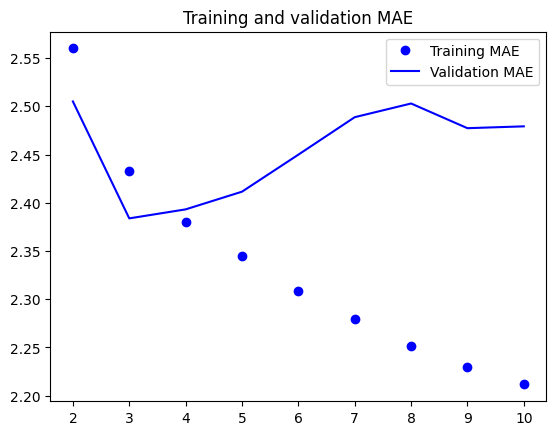

In [40]:
import matplotlib.pyplot as plt

loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs[1:], loss[1:], 'bo', label='Training MAE')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()


In [36]:
inputs = layers.Input(shape=(sequence_length, z.shape[-1]))
x = layers.Conv1D(filters=8, kernel_size=24, activation=activations.relu)(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=8, kernel_size=12, activation=activations.relu)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=8, kernel_size=6, activation=activations.relu)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callback_list = [
    callbacks.ModelCheckpoint('jena_conv', save_best_only=True)
]
model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callback_list)

model = keras.models.load_model('jena_conv')
print(model.evaluate(test_dataset))


Epoch 1/10
818/819 [============================>.] - ETA: 0s - loss: 20.3636 - mean_absolute_error: 3.5350INFO:tensorflow:Assets written to: jena_conv/assets


INFO:tensorflow:Assets written to: jena_conv/assets


819/819 [==============================] - 16s 19ms/step - loss: 20.3614 - mean_absolute_error: 3.5349 - val_loss: 14.8106 - val_mean_absolute_error: 3.0475
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 15.1129 - mean_absolute_error: 3.0805 - val_loss: 15.3430 - val_mean_absolute_error: 3.0980
Epoch 3/10
819/819 [==============================] - 16s 19ms/step - loss: 14.1148 - mean_absolute_error: 2.9708 - val_loss: 15.5968 - val_mean_absolute_error: 3.1088
Epoch 4/10
819/819 [==============================] - 16s 20ms/step - loss: 13.3542 - mean_absolute_error: 2.8920 - val_loss: 16.3211 - val_mean_absolute_error: 3.1854
Epoch 5/10
817/819 [============================>.] - ETA: 0s - loss: 12.7898 - mean_absolute_error: 2.8332INFO:tensorflow:Assets written to: jena_conv/assets


INFO:tensorflow:Assets written to: jena_conv/assets


819/819 [==============================] - 17s 20ms/step - loss: 12.7851 - mean_absolute_error: 2.8326 - val_loss: 14.2359 - val_mean_absolute_error: 2.9697
Epoch 6/10
819/819 [==============================] - 16s 20ms/step - loss: 12.2622 - mean_absolute_error: 2.7726 - val_loss: 17.7152 - val_mean_absolute_error: 3.3566
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 11.8562 - mean_absolute_error: 2.7265 - val_loss: 15.0074 - val_mean_absolute_error: 3.0574
Epoch 8/10
819/819 [==============================] - 16s 19ms/step - loss: 11.5098 - mean_absolute_error: 2.6859 - val_loss: 14.5471 - val_mean_absolute_error: 2.9813
Epoch 9/10
819/819 [==============================] - 16s 19ms/step - loss: 11.2200 - mean_absolute_error: 2.6532 - val_loss: 14.2792 - val_mean_absolute_error: 2.9612
Epoch 10/10
817/819 [============================>.] - ETA: 0s - loss: 10.9435 - mean_absolute_error: 2.6185INFO:tensorflow:Assets written to: jena_conv/assets


INFO:tensorflow:Assets written to: jena_conv/assets


405/405 [==============================] - 5s 12ms/step - loss: 15.0203 - mean_absolute_error: 3.0169
[15.02028751373291, 3.016899585723877]


In [38]:
inputs = layers.Input(shape=(sequence_length, z.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callback_list = [
    callbacks.ModelCheckpoint('jena_lstm', save_best_only=True)
]
model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callback_list)
model = keras.models.load_model('jena_lstm')
print(model.evaluate(test_dataset))

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 38.9484 - mean_absolute_error: 4.5268INFO:tensorflow:Assets written to: jena_lstm/assets


INFO:tensorflow:Assets written to: jena_lstm/assets


819/819 [==============================] - 27s 32ms/step - loss: 38.9484 - mean_absolute_error: 4.5268 - val_loss: 12.3681 - val_mean_absolute_error: 2.6698
Epoch 2/10
818/819 [============================>.] - ETA: 0s - loss: 10.8370 - mean_absolute_error: 2.5600INFO:tensorflow:Assets written to: jena_lstm/assets


INFO:tensorflow:Assets written to: jena_lstm/assets


819/819 [==============================] - 26s 31ms/step - loss: 10.8366 - mean_absolute_error: 2.5600 - val_loss: 11.1824 - val_mean_absolute_error: 2.5051
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 9.6958 - mean_absolute_error: 2.4327INFO:tensorflow:Assets written to: jena_lstm/assets


INFO:tensorflow:Assets written to: jena_lstm/assets


819/819 [==============================] - 26s 31ms/step - loss: 9.6958 - mean_absolute_error: 2.4327 - val_loss: 9.4364 - val_mean_absolute_error: 2.3838
Epoch 4/10
819/819 [==============================] - 25s 30ms/step - loss: 9.2904 - mean_absolute_error: 2.3798 - val_loss: 9.5924 - val_mean_absolute_error: 2.3932
Epoch 5/10
819/819 [==============================] - 25s 31ms/step - loss: 9.0018 - mean_absolute_error: 2.3445 - val_loss: 9.6191 - val_mean_absolute_error: 2.4115
Epoch 6/10
819/819 [==============================] - 25s 31ms/step - loss: 8.7599 - mean_absolute_error: 2.3090 - val_loss: 10.0014 - val_mean_absolute_error: 2.4499
Epoch 7/10
819/819 [==============================] - 25s 31ms/step - loss: 8.5629 - mean_absolute_error: 2.2800 - val_loss: 10.6349 - val_mean_absolute_error: 2.4887
Epoch 8/10
819/819 [==============================] - 25s 31ms/step - loss: 8.3590 - mean_absolute_error: 2.2511 - val_loss: 10.9903 - val_mean_absolute_error: 2.5029
Epoch 9/10
8